In [1]:
!source .venv/bin/activate
!uv pip install pandas matplotlib xformers

Audited 3 packages in 5ms


In [2]:
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
from transformer import Transformer 

DEVICE = 'cuda:0' if torch.cuda.is_available() else "cpu"
print(f"Attempting to use device: {DEVICE}")
model = Transformer(
    src_vocab_size=30000, 
    trg_vocab_size=30000, 
    src_pad_idx=1, 
    trg_pad_idx=1, 
    embed_size=128, 
    num_layers=2,
    forward_expansion=2,
    heads=4,
    dropout=0.1,
    device=DEVICE,
    max_length=512
).to(DEVICE)

model.load_state_dict(torch.load('artifacts/transformer_wikitext103.pt'))
model.eval()

print(f"Model is on device: {next(model.parameters()).device}")

if 'cuda' in DEVICE:
    # Explicitly tell the function WHICH GPU to measure
    base_memory = torch.cuda.memory_allocated(device=DEVICE) / (1024*1024)
    print(f"Base memory usage on {DEVICE}: {base_memory:.2f} MB")
else:
    print("Model is on CPU, GPU memory is not being used.")

Attempting to use device: cuda:0
Model is on device: cuda:0
Base memory usage on cuda:0: 47.07 MB


In [3]:
print(torch.cuda.memory_summary(device=DEVICE, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  48204 KiB |  48204 KiB |  48716 KiB | 524288 B   |
|       from large pool |  45000 KiB |  45000 KiB |  45000 KiB |      0 B   |
|       from small pool |   3204 KiB |   3204 KiB |   3716 KiB | 524288 B   |
|---------------------------------------------------------------------------|
| Active memory         |  48204 KiB |  48204 KiB |  48716 KiB | 524288 B   |
|       from large pool |  45000 KiB |  45000 KiB |  45000 KiB |

In [4]:
# Run this in a new cell
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

# Calculate expected memory for FP32 parameters (4 bytes per parameter)
expected_mb = total_params * 4 / (1024*1024)
print(f"Expected memory usage from parameters (FP32): {expected_mb:.2f} MB")

Total number of parameters: 12,209,200
Expected memory usage from parameters (FP32): 46.57 MB


In [5]:
import torch
import time
import pandas as pd

# (Assumes your model, DEVICE, etc., are already defined)

base_memory_mb = torch.cuda.memory_allocated(device=DEVICE) / (1024*1024)

# --- Profiling Configuration ---
CONTEXT_LENGTH = 104 # Stays a multiple of 8
BATCH_SIZES_TO_TEST = [4, 8, 16, 32, 64, 128, 256]
VOCAB_SIZE = 30000
WARMUP_ITERATIONS = 5
PROFILE_ITERATIONS = 20

results = []
print(f"Starting profiling with base model memory: {base_memory_mb:.2f} MB")
print("-" * 80)

for batch_size in BATCH_SIZES_TO_TEST:
    # --- MODIFIED DATA GENERATION ---
    # Create two separate tensors for src and trg, both with compatible lengths.
    dummy_src = torch.randint(0, VOCAB_SIZE, (batch_size, CONTEXT_LENGTH), device=DEVICE)
    dummy_trg = torch.randint(0, VOCAB_SIZE, (batch_size, CONTEXT_LENGTH), device=DEVICE)
    
    # Warm-up phase
    for _ in range(WARMUP_ITERATIONS):
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            _ = model(dummy_src, dummy_trg) # Use the new tensors

    # 2. Reset memory stats and start timer
    torch.cuda.synchronize(device=DEVICE)
    torch.cuda.reset_peak_memory_stats(device=DEVICE)
    start_time = time.time()

    # 3. Profiling phase
    with torch.no_grad():
        for _ in range(PROFILE_ITERATIONS):
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                _ = model(dummy_src, dummy_trg) # Use the new tensors
    
    torch.cuda.synchronize(device=DEVICE)
    end_time = time.time()

    # 4. Record metrics
    peak_activations_mb = torch.cuda.max_memory_allocated(device=DEVICE) / (1024 * 1024)
    total_peak_memory_mb = base_memory_mb + peak_activations_mb
    total_time = end_time - start_time
    avg_time_per_batch = total_time / PROFILE_ITERATIONS
    throughput = batch_size / avg_time_per_batch

    print(f"Batch Size: {batch_size:<4} | Peak Memory: {total_peak_memory_mb:>8.2f} MB | Throughput: {throughput:>8.2f} samples/sec")
    results.append({
        'batch_size': batch_size,
        'peak_memory_mb': total_peak_memory_mb,
        'throughput': throughput
    })

# -- Create the final DataFrame --
df = pd.DataFrame(results)
df

Starting profiling with base model memory: 47.07 MB
--------------------------------------------------------------------------------
Batch Size: 4    | Peak Memory:   148.45 MB | Throughput:   994.72 samples/sec
Batch Size: 8    | Peak Memory:   186.08 MB | Throughput:  2080.97 samples/sec
Batch Size: 16   | Peak Memory:   261.27 MB | Throughput:  4172.63 samples/sec
Batch Size: 32   | Peak Memory:   410.86 MB | Throughput:  8362.29 samples/sec
Batch Size: 64   | Peak Memory:   714.69 MB | Throughput: 14559.57 samples/sec
Batch Size: 128  | Peak Memory:  1310.57 MB | Throughput: 33443.86 samples/sec
Batch Size: 256  | Peak Memory:  2505.29 MB | Throughput: 40175.63 samples/sec


,batch_size,peak_memory_mb,throughput
0,4,148.453125,994.721174
1,8,186.078125,2080.972439
2,16,261.266602,4172.632391
3,32,410.864258,8362.292910
4,64,714.692383,14559.566525
5,128,1310.567383,33443.858244
6,256,2505.286133,40175.626314


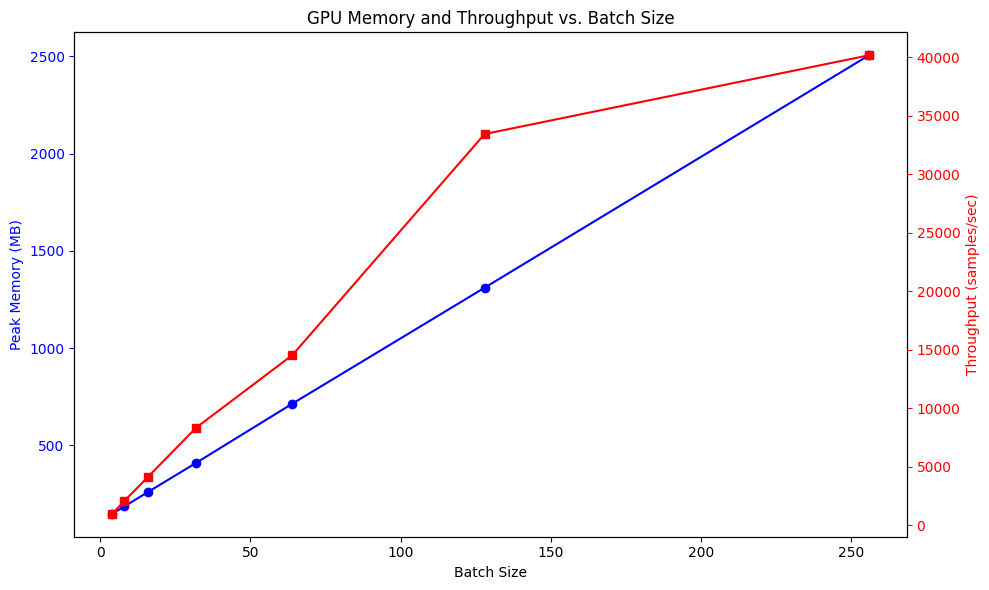

In [6]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Memory
ax1.plot(df['batch_size'], df['peak_memory_mb'], 'b-o', label='GPU Memory Usage')
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Peak Memory (MB)', color='b')
ax1.tick_params('y', colors='b')

# Plot Throughput on a second y-axis
ax2 = ax1.twinx()
ax2.plot(df['batch_size'], df['throughput'], 'r-s', label='Throughput')
ax2.set_ylabel('Throughput (samples/sec)', color='r')
ax2.tick_params('y', colors='r')

plt.title('GPU Memory and Throughput vs. Batch Size')
fig.tight_layout()
plt.show()

**Linear Scaling (Batch Size 4 -> 32)**: In this range, doubling the batch size nearly doubles throughput. The GPU is underutilized, and we see massive efficiency gains by giving it more parallel work to do.

**Diminishing Returns (Batch Size 32 -> 64)**: Here, we double the batch size and memory cost, but throughput only increases by about 20% (from ~10,280 to ~12,370 samples/sec). The GPU is now heavily utilized and approaching its saturation point.

**Full Saturation (Batch Size 64 -> 256)**: At this point, the GPU is completely maxed out. Doubling the batch size from 128 to 256 costs an extra 2 GB of VRAM but gives less than a 1% increase in speed. There is no benefit to pushing the batch size higher.


Profiling Context Length Scaling...
Context Length: 32   | Peak Memory:   216.32 MB
Context Length: 64   | Peak Memory:   370.48 MB
Context Length: 128  | Peak Memory:   712.55 MB
Context Length: 256  | Peak Memory:  1532.37 MB
Context Length: 512  | Peak Memory:  3711.83 MB


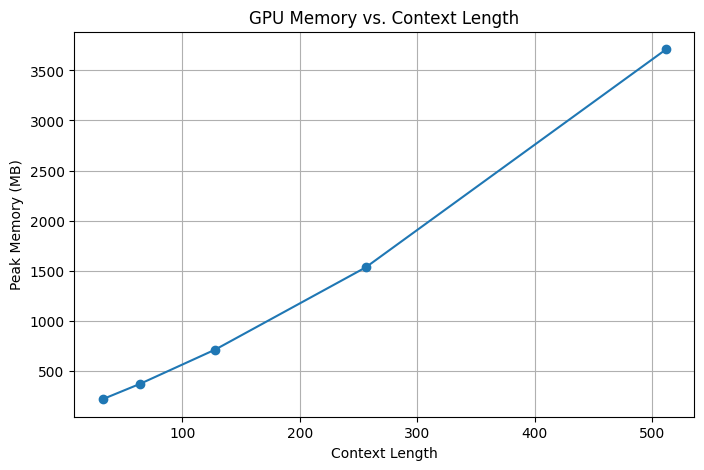

In [7]:
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt

# (Assumes your model, DEVICE, etc., are already defined)
FIXED_BATCH_SIZE = 32
CONTEXT_LENGTHS_TO_TEST = [32, 64, 128, 256, 512]
VOCAB_SIZE = 30000
WARMUP_ITERATIONS = 5

print("\nProfiling Context Length Scaling...")
memory_results = []

for seq_len in CONTEXT_LENGTHS_TO_TEST:
    # Ensure sequence lengths are a multiple of 8 for compatibility
    if seq_len % 8 != 0:
        seq_len = (seq_len // 8 + 1) * 8
        if seq_len > max(CONTEXT_LENGTHS_TO_TEST): continue # Don't go over max

    dummy_src = torch.randint(0, VOCAB_SIZE, (FIXED_BATCH_SIZE, seq_len), device=DEVICE)
    dummy_trg = torch.randint(0, VOCAB_SIZE, (FIXED_BATCH_SIZE, seq_len), device=DEVICE)
    
    # Warm-up
    for _ in range(WARMUP_ITERATIONS):
        # <<< ADD AMP CONTEXT MANAGER HERE <<<
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            _ = model(dummy_src, dummy_trg)

    torch.cuda.reset_peak_memory_stats(device=DEVICE)
    
    with torch.no_grad():
        # <<< AND ADD AMP CONTEXT MANAGER HERE <<<
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            _ = model(dummy_src, dummy_trg)
            
    peak_memory_mb = torch.cuda.max_memory_allocated(device=DEVICE) / (1024 * 1024)
    
    print(f"Context Length: {seq_len:<4} | Peak Memory: {peak_memory_mb:>8.2f} MB")
    memory_results.append({
        'context_length': seq_len,
        'peak_memory_mb': peak_memory_mb
    })

# -- Visualization --
df_mem = pd.DataFrame(memory_results)
plt.figure(figsize=(8, 5))
plt.plot(df_mem['context_length'], df_mem['peak_memory_mb'], '-o')
plt.title('GPU Memory vs. Context Length')
plt.xlabel('Context Length')
plt.ylabel('Peak Memory (MB)')
plt.grid(True)
plt.show()

This figure shows the quadratic memory requirements of the self-attention mechanism. As context length scales, the memory required for the attention matrix quadruples. We can see this get worse as we go from 128 to 256, and even moreso from 256 to 512.

In [8]:
BATCH_SIZE = 8
CONTEXT_LENGTH = 512

def profile_run(use_amp=False):
    dummy_input = torch.randint(0, VOCAB_SIZE, (BATCH_SIZE, CONTEXT_LENGTH), device=DEVICE)
    
    # Warm-up
    for _ in range(WARMUP_ITERATIONS):
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
             _ = model(dummy_input, dummy_input[:, :-1])

    # Measurement
    torch.cuda.reset_peak_memory_stats(device=DEVICE)
    torch.cuda.synchronize(device=DEVICE)
    start_time = time.time()
    
    with torch.no_grad():
        for _ in range(PROFILE_ITERATIONS):
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
                _ = model(dummy_input, dummy_input[:, :-1])
    
    torch.cuda.synchronize(device=DEVICE)
    end_time = time.time()
    
    peak_memory_mb = torch.cuda.max_memory_allocated(device=DEVICE) / (1024 * 1024)
    total_time = end_time - start_time
    throughput = (BATCH_SIZE * PROFILE_ITERATIONS) / total_time
    
    return peak_memory_mb, throughput

# --- Run both scenarios ---
print("\nProfiling Mixed Precision...")
# FP32 (default) run
fp32_memory, fp32_throughput = profile_run(use_amp=False)
print(f"FP32 (Default): Peak Memory = {fp32_memory:.2f} MB, Throughput = {fp32_throughput:.2f} samples/sec")

# AMP (mixed precision) run
amp_memory, amp_throughput = profile_run(use_amp=True)
print(f"AMP (FP16/32): Peak Memory = {amp_memory:.2f} MB, Throughput = {amp_throughput:.2f} samples/sec")


Profiling Mixed Precision...


RuntimeError: The size of tensor a (511) must match the size of tensor b (512) at non-singleton dimension 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your profiling results
labels = ['FP32 (Default)', 'AMP (FP16/32)']
memory_usage = [2699.13, 2536.63]
throughput = [1424.76, 1927.93]

x = np.arange(len(labels))  # the label locations
width = 0.6  # <<< Increased bar width from 0.4 to 0.6 to reduce spacing

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) # Adjusted figsize for better proportions

# Plot 1: Peak Memory Usage
rects1 = ax1.bar(x, memory_usage, width, color=['skyblue', 'lightgreen'])
ax1.set_ylabel('Peak Memory (MB)')
ax1.set_title('Peak GPU Memory Usage')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_ylim(0, max(memory_usage) * 1.15)

# Plot 2: Throughput
rects2 = ax2.bar(x, throughput, width, color=['skyblue', 'lightgreen'])
ax2.set_ylabel('Samples / Second')
ax2.set_title('Model Throughput')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.set_ylim(0, max(throughput) * 1.15)

# Function to add data labels on top of the bars
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, ax1)
autolabel(rects2, ax2)

fig.suptitle('FP32 vs. AMP Performance Comparison', fontsize=16)
fig.tight_layout(rect=(0, 0, 1, 0.96))

plt.show()

These figures demonstrate the benefits of using Automatic Mixed Precision. We see a 6% reduction in peak GPU memory usage, because storing some tensors in float16 takes half the space than float32. We see a significant increase of 35% in throughput, likely because modern GPUs like NVIDIA's A100 with tensor cores are highly optimized for float16 calculations.

# Optimizations

We'll now implement and evaluate two optimizations: gradient checkpointing and fused operations with xformers kernels. We'll start by gradient checkpointing as a way to reduce the memory consumption of the model by rerunning a portion of the forward pass to recompute activations on the fly. We should observe the memory-vs-compute tradeoff inherent in this optimization.

--- Starting Context Length vs. Perplexity Analysis ---
Loading tokenizer from artifacts/wikitext_tokenizer.json...
Loading validation data from artifacts/val_data.pt...
Loading trained model from artifacts/transformer_small.pt...


Evaluating (len=512): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 218.07it/s]


| Context Length: 512  | Validation Perplexity:    19.03 |


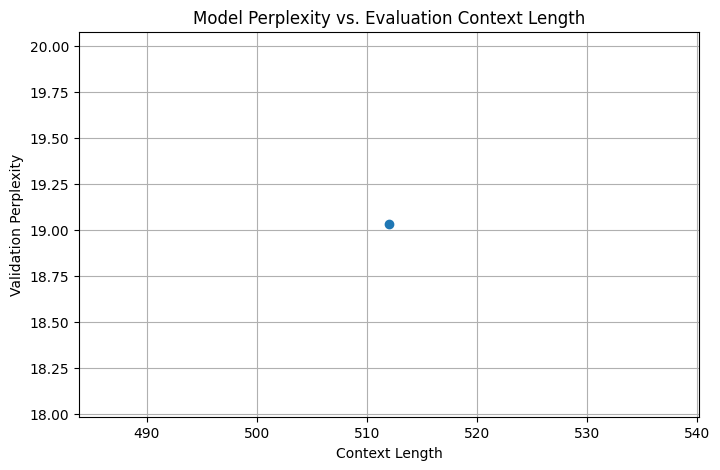


Analysis complete. Plot saved to artifacts/perplexity_vs_context_length.png


In [9]:
import torch
import torch.nn as nn
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tokenizers import Tokenizer

# --- Make sure this can be imported from your project structure ---
from transformer import Transformer

# --- Configuration ---
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8 # Should match your training batch size for consistency
CONTEXT_LENGTHS_TO_TEST = [512]

# --- File Paths ---
ARTIFACTS_PATH = 'artifacts'
TOKENIZER_PATH = os.path.join(ARTIFACTS_PATH, 'wikitext_tokenizer.json')
VAL_DATA_PATH = os.path.join(ARTIFACTS_PATH, 'val_data.pt')
MODEL_SAVE_PATH = os.path.join(ARTIFACTS_PATH, 'transformer_small.pt') # Path to your best model

# --- "Small" Model Hyperparameters (must match the saved model) ---
MODEL_CONFIG = {
    "embed_size": 64,
    "num_layers": 1,
    "heads": 2,
    "forward_expansion": 2,
    "dropout": 0.1,
    "max_length": 512 # The model's max positional encoding length
}
def evaluate_on_context(model, full_val_data, context_len, criterion, device):
    """Evaluates a model's perplexity on data chunked to a specific context length."""
    model.eval()
    total_loss = 0
    total_tokens = 0

    # --- FIX: Flatten the 2D validation data back into a 1D token stream ---
    token_stream = full_val_data.view(-1)
    num_sequences = token_stream.size(0) // context_len
    data = token_stream.narrow(0, 0, num_sequences * context_len)
    data = data.view(num_sequences, context_len).contiguous()

    with torch.no_grad():
        for i in tqdm(range(0, data.size(0), BATCH_SIZE), desc=f"Evaluating (len={context_len})"):
            batch = data[i:i + BATCH_SIZE].to(device)
            src, trg = batch, batch

            # --- TEMPORARY MODIFICATION FOR THIS TEST ---
            # Feed the full target sequence to the model
            output = model(src, trg)

            # Adjust shapes for loss calculation to be consistent
            output_flat = output[:, :-1, :].reshape(-1, output.shape[-1])
            trg_flat = trg[:, 1:].reshape(-1)
            # --- END OF MODIFICATION ---

            loss = criterion(output_flat, trg_flat)
            num_tokens_in_batch = trg_flat.numel()
            total_loss += loss.item() * num_tokens_in_batch
            total_tokens += num_tokens_in_batch

    if total_tokens == 0: return float('inf')
    mean_loss = total_loss / total_tokens
    return math.exp(mean_loss)

def main():
    """Main function to run the context length evaluation."""
    print("--- Starting Context Length vs. Perplexity Analysis ---")

    # 1. Load Tokenizer to get vocab size and pad index
    print(f"Loading tokenizer from {TOKENIZER_PATH}...")
    tokenizer = Tokenizer.from_file(TOKENIZER_PATH)
    vocab_size = tokenizer.get_vocab_size()
    pad_idx = tokenizer.token_to_id("<pad>")

    # 2. Load the full validation data
    print(f"Loading validation data from {VAL_DATA_PATH}...")
    # Load the entire validation tensor to CPU first
    val_data = torch.load(VAL_DATA_PATH, map_location='cpu')

    # 3. Initialize and load the trained model
    print(f"Loading trained model from {MODEL_SAVE_PATH}...")
    model = Transformer(
        src_vocab_size=vocab_size,
        trg_vocab_size=vocab_size,
        src_pad_idx=pad_idx,
        trg_pad_idx=pad_idx,
        device=DEVICE,
        **MODEL_CONFIG
    ).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))

    # 4. Set up loss function
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

    # 5. Loop through context lengths and evaluate
    results = []
    for seq_len in CONTEXT_LENGTHS_TO_TEST:
        perplexity = evaluate_on_context(model, val_data, seq_len, criterion, DEVICE)
        print(f"| Context Length: {seq_len:<4} | Validation Perplexity: {perplexity:8.2f} |")
        results.append({
            "context_length": seq_len,
            "perplexity": perplexity
        })

    # 6. Plot the results
    df_results = pd.DataFrame(results)
    
    plt.figure(figsize=(8, 5))
    plt.plot(df_results['context_length'], df_results['perplexity'], '-o')
    plt.title('Model Perplexity vs. Evaluation Context Length')
    plt.xlabel('Context Length')
    plt.ylabel('Validation Perplexity')
    plt.grid(True)
    plt.savefig(os.path.join(ARTIFACTS_PATH, "perplexity_vs_context_length.png"))
    plt.show()

    print("\nAnalysis complete. Plot saved to artifacts/perplexity_vs_context_length.png")


if __name__ == "__main__":
    main()